In [16]:
import re
import nltk
import pickle
import pyLDAvis
import pyLDAvis.gensim
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ignis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ignis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ignis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ignis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Pre-processing stuff

In [3]:
exclude = ['wheat', 'ndvi', 'yield', 'index', 'used', 'study', 'yields',
           'figure', 'table', 'crop', 'grain', 'data', 'values', 'using', 
           'das', 'org', 'https', 'indices', 'cambridge', 'fig', 'based']
lemma = WordNetLemmatizer()


# Preprocess function
def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W+', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [lemma.lemmatize(word) for word in tokens if (word not in stopwords.words('english')) & (word.isalpha()) & (len(word) > 2) & (word not in  exclude)]
    return tokens

### Loading abstracts saved

In [4]:
with open('abstract/abstracts.pkl', 'rb') as f:
    mynewlist = pickle.load(f)

### Cleaning abstracts and dictionary and corpus generation

In [5]:
# Preprocess documents
cleaned_documents = [preprocess(doc) for doc in mynewlist]

# Create a Gensim dictionary (maps words to unique IDs)
dictionary = Dictionary(cleaned_documents)
dictionary.filter_extremes(no_below=5, no_above=0.8)
# Convert documents into Bag-of-Words (BoW) format
corpus = [dictionary.doc2bow(doc) for doc in cleaned_documents]

### Setting number of topics based on coherence search

In [7]:
cohe = []
for n in range(1, 30):
    n_topics = n
    
    # Train the LDA model
    lda_model = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, random_state=42, passes=10, iterations=50)
    coherence_model = CoherenceModel(model=lda_model, texts=cleaned_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(n, coherence_score)
    cohe.append(coherence_score)

1 0.3131632749269663
2 0.3463469852561647
3 0.430446746385031
4 0.4488423965591819
5 0.458004051671819
6 0.4406702703881347
7 0.4295771105599457
8 0.4546196515122478
9 0.4314436382168376
10 0.40974343561597193
11 0.41227611849411955
12 0.4117090180226442
13 0.40917163850628263
14 0.3987671225270203
15 0.4094540261218962
16 0.3862611192137477
17 0.38518539351763154
18 0.40143966625216726
19 0.3899832125825437
20 0.39107022026753147
21 0.38151888466946626
22 0.3774081908224399
23 0.3702505751158375
24 0.3825329733977836
25 0.3859619167663243
26 0.38904307767430635
27 0.36941833082020237
28 0.371106693987118
29 0.37955277449620406


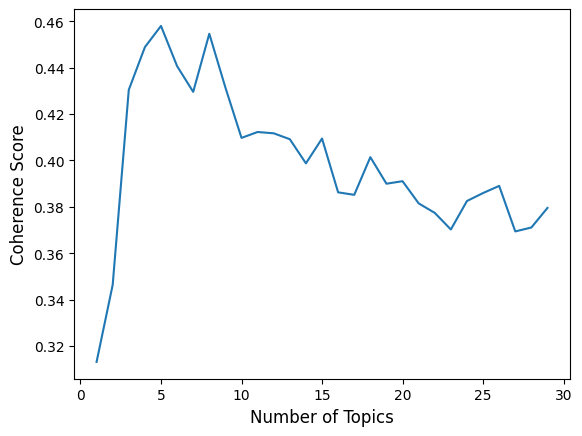

In [9]:
plt.plot(range(1,30), cohe)
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Coherence Score", fontsize=12)
# plt.savefig('coherence.png', dpi=300, bbox_inches='tight')
plt.show()

### Training LDA model

In [10]:
# Number of topics
n_topics = 5

# Train the LDA model
lda_model = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, random_state=42, passes=10, iterations=50)

# Print the topics and their top words
for i, topic in lda_model.show_topics(num_topics=n_topics, num_words=6, formatted=False):
    print(f"Topic {i + 1}: {[word for word, prob in topic]}")

Topic 1: ['vegetation', 'stage', 'spectral', 'growth', 'difference', 'canopy']
Topic 2: ['drought', 'trait', 'condition', 'genotype', 'stress', 'winter']
Topic 3: ['model', 'vegetation', 'winter', 'estimation', 'time', 'result']
Topic 4: ['area', 'water', 'vegetation', 'winter', 'year', 'soil']
Topic 5: ['nitrogen', 'application', 'rate', 'field', 'fertilizer', 'sensor']


### Topics and interclass distance

In [11]:
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(panel)

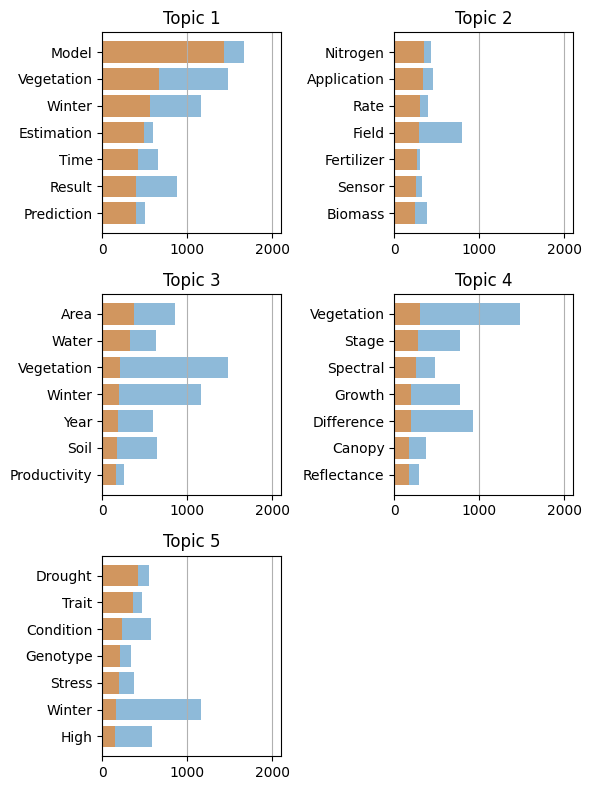

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(6, 8))

for i in range(1, 6):
    df = panel.sorted_terms(i)
    if i < 3:
        j = i - 1
        ax[0, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Total'][::-1], alpha=0.5)
        ax[0, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Freq'][::-1], alpha=0.6)
        ax[0, j].set_title(f"Topic {i}")
        ax[0, j].set_xlim(0, 2100)
        ax[0, j].grid(axis='x')
        
    elif (i >= 3) & (i < 5):
        j = i - 3
        ax[1, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Total'][::-1], alpha=0.5)
        ax[1, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Freq'][::-1], alpha=0.6)
        ax[1, j].set_title(f"Topic {i}")
        ax[1, j].set_xlim(0, 2100)
        ax[1, j].grid(axis='x')

    else:
        j = i - 5
        ax[2, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Total'][::-1], alpha=0.5)
        ax[2, j].barh(df.head(7)['Term'][::-1].str.capitalize(), 
                          df.head(7)['Freq'][::-1], alpha=0.6)
        ax[2, j].set_title(f"Topic {i}")
        ax[2, j].set_xlim(0, 2100)
        ax[2, j].grid(axis='x')
        

    ax[2, 1].axis('off')
            
plt.tight_layout()
# plt.savefig('LDA_freq.png', dpi=300)
plt.show()

    

### Co-occurring topics

In [13]:
def get_topic_titles(lda_model, topn=3):
    topics = lda_model.show_topics(num_topics=-1, num_words=topn, formatted=False)
    return {topic[0]: " ".join([word for word, _ in topic[1]]) for topic in topics}

In [14]:
labels = ['Topic 4', 'Topic 5', 'Topic 1', 'Topic 3', 'Topic 2']
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]
most_likely_topics = [max(topics, key=lambda x: x[1])[0] for topics in topic_distributions]
all_probabilities = [prob for topics in topic_distributions for _, prob in topics]
topic_titles = get_topic_titles(lda_model)

In [17]:
# Set threshold as the 90th percentile of all topic probabilities
threshold = np.percentile(all_probabilities, 50)

# threshold = 0.02
co_occurrence_matrix = Counter()
for topics in topic_distributions:
    top_topics = [topic[0] for topic in topics if topic[1] > threshold]  # Use a threshold for multiple topics
    co_occurrence_matrix.update(combinations(top_topics, 2))

# Example: Heatmap visualization
topics = list(range(lda_model.num_topics))
print(topics, topic_titles)
matrix = np.zeros((len(topics), len(topics)))
for (t1, t2), count in co_occurrence_matrix.items():
    matrix[t1, t2] = count
    matrix[t2, t1] = count

[0, 1, 2, 3, 4] {0: 'vegetation stage spectral', 1: 'drought trait condition', 2: 'model vegetation winter', 3: 'area water vegetation', 4: 'nitrogen application rate'}


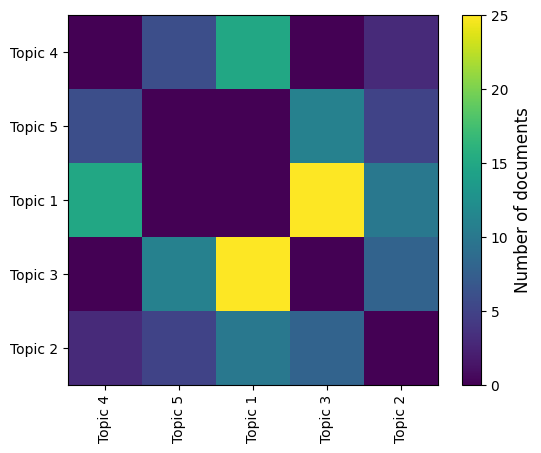

In [18]:
plt.imshow(matrix, cmap="viridis")#xticklabels=topics, yticklabels=topics, )
cb = plt.colorbar()
cb.set_label('Number of documents', fontsize=12)
plt.xticks(range(5), labels)#['4', '5', '1', '3', '2'])
plt.yticks(range(5), labels)
plt.tick_params(axis='x', rotation=90)
# plt.savefig('co-occurrence.png', dpi=300, bbox_inches='tight')

plt.show()